In [ ]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'DejaVu Sans'
import seaborn as sns

# To be able to save images on server
import matplotlib
%matplotlib inline
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Importing tensorflow
np.random.seed(42)
import tensorflow as tf


from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM , BatchNormalization
from keras.layers.core import Dense, Dropout
from keras.regularizers import L1L2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [1]:
reformed_xdata=np.load(r'C:\Users\ASUS\Documents\school\Untitled Folder\SleepySignals_X.npy')

NameError: name 'np' is not defined

In [7]:
reformed_ydata=np.load(r'C:\Users\ASUS\Documents\school\Untitled Folder\SleepySignals_y.npy')

In [15]:
lb = preprocessing.LabelBinarizer()

In [16]:
lb.fit(reformed_ydata)

LabelBinarizer()

In [17]:
reformed_ydata_binary=lb.transform(reformed_ydata)

In [18]:
xdata=np.asarray(reformed_xdata)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(xdata, reformed_ydata_binary, test_size=0.2, random_state=42)

In [20]:
timesteps = len(x_train[0])
input_dim = len(x_train[0][0])
n_classes = len(y_train[0])

In [21]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [22]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'W',
    1: 'N1',
    2: 'N2',
    3: 'N3/N4',
    4: 'REM'
}


# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "channel1_gyo_x",
    "channel1_gyo_y",
    "channel1_gyo_z",
    "channel2_gyo_x",
    "channel2_gyo_y",
    "channel2_gyo_z",
    
    
    "channel1_acc_x",
    "channel1_acc_y",
    "channel1_acc_z",
    "channel2_acc_x",
    "channel2_acc_y",
    "channel2_acc_z",
    
    "EEG1 channel 1",
    "EEG1 channel 2",
    "EEG2 channel 1",
    "EEG2 channel 2",
]

In [23]:
def confusion_matrix_dl(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [24]:
def plot_train_cv_loss(trained_model, epochs, colors=['b']):
    fig, ax = plt.subplots(1,1)    
    ax.set_xlabel('epoch') 
    ax.set_ylabel('Categorical Crossentropy Loss')
    x_axis_values = list(range(1,epochs+1))

    validation_loss = trained_model.history['val_loss']
    train_loss = trained_model.history['loss']   
    
    ax.plot(x_axis_values, validation_loss, 'b', label="Validation Loss")
    ax.plot(x_axis_values, train_loss, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw() 

In [25]:
def plot_confusion_matrix_lstm(y_test, y_predict):
    result = confusion_matrix(y_test, y_predict)

    plt.figure(figsize=(12, 10))
    sns.heatmap(result, 
                xticklabels= list(ACTIVITIES.values()), 
                yticklabels=list(ACTIVITIES.values()), 
                annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 

In [26]:
n_steps = 30;
n_length = 100;
n_features =input_dim ;

x_train = x_train.reshape((x_train.shape[0], n_steps, n_length, n_features))
x_test = x_test.reshape((x_test.shape[0], n_steps, n_length, n_features))

In [27]:
from keras.layers import TimeDistributed, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [28]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
print("Model Summary: ")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 98, 64)      3136      
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 96, 64)      12352     
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 96, 64)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 48, 64)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 3072)        0         
_________________________________________________________________
lstm_

In [29]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
start = datetime.now()
n_epochs=20;n_batch = 16;
# Training the model
trained_model_CNN_LSTM  = model.fit(x_train,
                           y_train,
                           batch_size=n_batch,
                           validation_data=(x_test, y_test),
                           epochs=n_epochs,callbacks=[callback])

print("\n Time Taken: ",datetime.now() - start)

Instructions for updating:
Use tf.cast instead.
Train on 7856 samples, validate on 1964 samples
Epoch 1/20
7856/7856 [==============================] - 205s 26ms/step - loss: 0.7194 - acc: 0.7503 - val_loss: 0.4410 - val_acc: 0.8651
Epoch 2/20
 912/7856 [==>...........................] - ETA: 3:15 - loss: 0.4336 - acc: 0.8531

KeyboardInterrupt: 

In [31]:
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D, TimeDistributed, Bidirectional, LSTM
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, MaxPool1D, Activation
from tensorflow.keras.layers import Reshape, LSTM, TimeDistributed, Bidirectional, BatchNormalization, Flatten, RepeatVector
from tensorflow.keras.optimizers import Adam
from keras_contrib.layers import CRF

In [34]:
WINDOW_SIZE = 100
Fs = 100

In [41]:
def model_b(n_classes=5, use_sub_layer=False, use_rnn=True, verbose=False):
    """Recurrent_Deep_Neural_Networks_for_Real-Time_Sleep
    """
    inputLayer = Input(shape=(3000, 16), name='inLayer')
    convFine = Conv1D(filters=64, kernel_size=int(Fs/2), strides=int(Fs/16), padding='same', activation='relu', name='fConv1')(inputLayer)
    convFine = MaxPool1D(pool_size=8, strides=8, name='fMaxP1')(convFine)
    convFine = Dropout(rate=0.5, name='fDrop1')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv2')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv3')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv4')(convFine)
    convFine = MaxPool1D(pool_size=4, strides=4, name='fMaxP2')(convFine)
    fineShape = convFine.get_shape()
    convFine = Flatten(name='fFlat1')(convFine)
    
    # network to learn coarse features
    convCoarse = Conv1D(filters=32, kernel_size=Fs*4, strides=int(Fs/2), padding='same', activation='relu', name='cConv1')(inputLayer)
    convCoarse = MaxPool1D(pool_size=4, strides=4, name='cMaxP1')(convCoarse)
    convCoarse = Dropout(rate=0.5, name='cDrop1')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv2')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv3')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv4')(convCoarse)
    convCoarse = MaxPool1D(pool_size=2, strides=2, name='cMaxP2')(convCoarse)
    coarseShape = convCoarse.get_shape()
    convCoarse = Flatten(name='cFlat1')(convCoarse)
    
    # concatenate coarse and fine cnns
    mergeLayer = concatenate([convFine, convCoarse], name='merge_1')
    outLayer = Dropout(rate=0.5, name='mDrop1')(mergeLayer)
    
    outLayer = Reshape((1, outLayer.get_shape()[1]), name='reshape1')(outLayer)
    outLayer = LSTM(64, return_sequences=True)(outLayer)
    outLayer = LSTM(64, return_sequences=False)(outLayer)

    # Classify
    outLayer = Dense(n_classes, activation='softmax', name='outLayer')(outLayer)
    model = Model(inputLayer, outLayer)
    optimizer = Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    if verbose:
        model.summary()
    return model

In [42]:
model_CRF=model_b()

In [39]:
x_train = x_train.reshape((x_train.shape[0],3000, n_features))
x_test = x_test.reshape((x_test.shape[0], 3000, n_features))

In [43]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
start = datetime.now()
n_epochs=30;n_batch=16;
# Training the model
trained_model_CRF= model_CRF.fit(x_train,
                           y_train,
                           batch_size=n_batch,
                           validation_data=(x_test, y_test),
                           epochs=n_epochs,callbacks=[callback])

print("\n Time Taken: ",datetime.now() - start)

Train on 7856 samples, validate on 1964 samples
Epoch 1/30
7856/7856 [==============================] - 74s 9ms/sample - loss: 1.0908 - acc: 0.6302 - val_loss: 0.9622 - val_acc: 0.6858
Epoch 2/30
7856/7856 [==============================] - 68s 9ms/sample - loss: 0.8896 - acc: 0.7219 - val_loss: 0.7869 - val_acc: 0.7704
Epoch 3/30
7856/7856 [==============================] - 69s 9ms/sample - loss: 0.7457 - acc: 0.7685 - val_loss: 0.6733 - val_acc: 0.7948
Epoch 4/30
7856/7856 [==============================] - 50s 6ms/sample - loss: 0.6561 - acc: 0.7851 - val_loss: 0.5512 - val_acc: 0.8065
Epoch 5/30
7856/7856 [==============================] - 55s 7ms/sample - loss: 0.5336 - acc: 0.8271 - val_loss: 0.4861 - val_acc: 0.8315
Epoch 6/30
7856/7856 [==============================] - 55s 7ms/sample - loss: 0.4440 - acc: 0.8633 - val_loss: 0.4086 - val_acc: 0.8712
Epoch 7/30
7856/7856 [==============================] - 57s 7ms/sample - loss: 0.3828 - acc: 0.8759 - val_loss: 0.3073 - val_acc: 

In [47]:
y_full_predicted=model_CRF.predict(xdata)

In [74]:
y_predicted=model_CRF.predict(x_test)

In [48]:
first_patient_duration=982;

In [49]:
Y_pred_value = [y for y in np.argmax(y_full_predicted, axis=1)]

In [60]:
Y_true_value = [y for y in np.argmax(reformed_ydata, axis=1)]

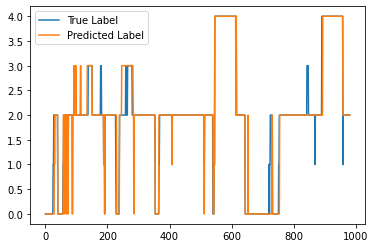

In [70]:
plt.plot(range(len(reformed_ydata[:first_patient_duration])),Y_true_value[:first_patient_duration],label='True Label')
plt.plot(range(len(reformed_ydata[:first_patient_duration])),Y_pred_value[:first_patient_duration],label='Predicted Label')
plt.legend()


Test Accuracy: 93.075359%



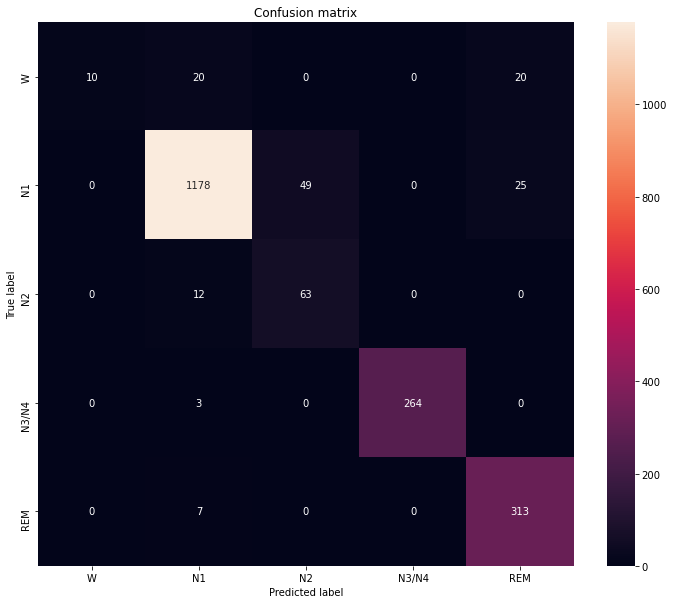

In [67]:
print()
scores = model_CRF.evaluate(x_test, y_test, verbose=0)
print("Test Accuracy: %f%%" % (scores[1]*100))
print()

Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model_CRF.predict(x_test), axis=1)])

# Confusion Matrix
plot_confusion_matrix_lstm(Y_true, Y_predictions)

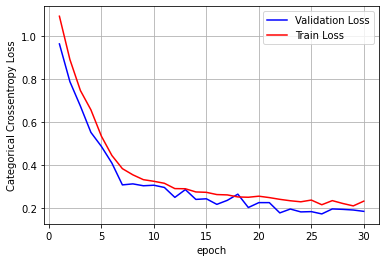

In [69]:
# Plot train and cross validation error
plot_train_cv_loss(trained_model_CRF, n_epochs)

In [103]:
from sklearn.metrics import classification_report, roc_curve, auc,roc_auc_score,cohen_kappa_score
from scipy import interp
from itertools import cycle

In [82]:
roc_auc_score(y_test, y_predicted, average="weighted", multi_class="ovr")

0.990111515313397

In [86]:
cohen_kappa_score(Y_true_value, Y_pred_value)

0.8633666592825981

In [93]:
print(classification_report(Y_true_value, Y_pred_value))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1680
           1       1.00      0.21      0.34       240
           2       0.96      0.93      0.95      6130
           3       0.54      0.79      0.65       390
           4       1.00      0.97      0.99      1380

    accuracy                           0.92      9820
   macro avg       0.87      0.78      0.77      9820
weighted avg       0.93      0.92      0.92      9820



In [99]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predicted[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_predicted.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

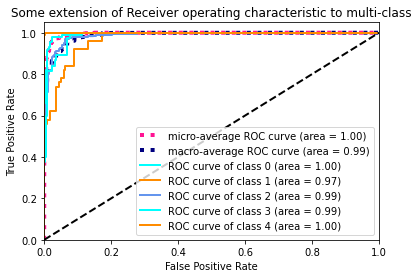

In [105]:
lw=2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()